## Heatmap

* Мы создадим две тепловые карты (heatmap): одну для анализа коммитов по дням недели, а другую — для анализа коммитов по часам.

#### 1. Подключаемся к базе

In [61]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

conn = sqlite3.connect('../data/checking-logs.sqlite')

#### 2. Загрузка данных 

In [62]:
query = """
SELECT uid, timestamp
FROM checker
WHERE uid NOT LIKE 'admin%'
"""
df = pd.read_sql_query(query, conn)

df.head()

,uid,timestamp
0,user_4,2020-04-17 05:19:02.744528
1,user_4,2020-04-17 05:22:35.249331
2,user_4,2020-04-17 05:22:45.549397
3,user_4,2020-04-17 05:34:14.691200
4,user_4,2020-04-17 05:34:24.422370


#### 3. Обработка данных

In [63]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['weekday'] = df['timestamp'].dt.day_name()
df['hour'] = df['timestamp'].dt.hour 

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday'] = pd.Categorical(df['weekday'], categories=weekday_order, ordered=True)

df_grouped = df.groupby(['uid', 'weekday', 'hour'], observed=False).size().reset_index(name='commits')

print(df.head())
print(df_grouped.head())

      uid                  timestamp weekday  hour
0  user_4 2020-04-17 05:19:02.744528  Friday     5
1  user_4 2020-04-17 05:22:35.249331  Friday     5
2  user_4 2020-04-17 05:22:45.549397  Friday     5
3  user_4 2020-04-17 05:34:14.691200  Friday     5
4  user_4 2020-04-17 05:34:24.422370  Friday     5
      uid weekday  hour  commits
0  user_0  Monday     0        0
1  user_0  Monday     1        0
2  user_0  Monday     3        0
3  user_0  Monday     5        0
4  user_0  Monday     6        0


#### 4. Потсроение хитмапа

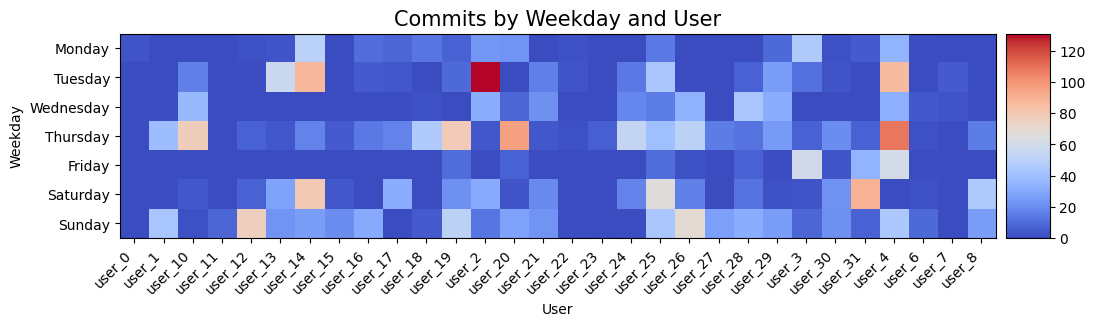

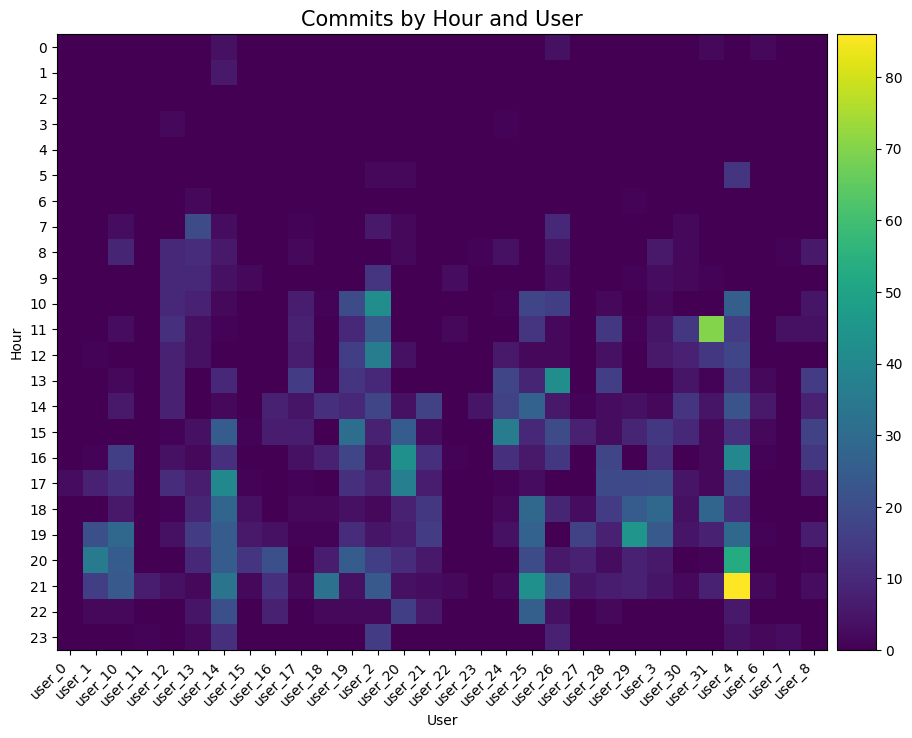

In [64]:
heatmap_weekday = df_grouped.pivot_table(index='weekday', columns='uid', values='commits', aggfunc='sum', fill_value=0, observed=False)

heatmap_weekday = heatmap_weekday.loc[weekday_order]
heatmap_weekday = heatmap_weekday.fillna(0)

def plot_heatmap(data, title, xlabel, ylabel, cmap='YlOrRd'):
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(data, cmap=cmap)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    
    ax.set_xticks(range(len(data.columns)))
    ax.set_xticklabels(data.columns, rotation=45, ha='right')
    ax.set_yticks(range(len(data.index)))
    ax.set_yticklabels(data.index)
    
    ax.set_title(title, fontsize=15)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    plt.show()

plot_heatmap(heatmap_weekday, 'Commits by Weekday and User', 'User', 'Weekday', cmap='coolwarm')

heatmap_hour = df_grouped.pivot_table(index='hour', columns='uid', values='commits', aggfunc='sum', fill_value=0)

heatmap_hour = heatmap_hour.reindex(range(24))
heatmap_hour = heatmap_hour.fillna(0)

plot_heatmap(heatmap_hour, 'Commits by Hour and User', 'User', 'Hour', cmap='viridis')


#### 5. Отвечаем на допы:

* “Which user has the most commits on Tue?”
* “Which user has the most commits on Thu?”
* “On which weekday do the users not like making a lot of commits?”
* “Which user at which hour made the largest number of commits?”

In [65]:
print("1. The answer is: user_2.")
print("2. The answer is: user_4.")
print("3. The answer is: Monday or Friday.")
print("4. The answer is: user_4, hour 21.")

1. The answer is: user_2.
2. The answer is: user_4.
3. The answer is: Monday or Friday.
4. The answer is: user_4, hour 21.


In [66]:
conn.close()